In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import re

from tqdm import tqdm

import matplotlib.pyplot as plt


import sys
sys.path.append('/Users/rdcrlzh1/Documents/SWE_error_analysis/src')
from swe_retrievals import swe_from_phase
from non_snow_retrievals import precipitable_water, ionospheric_advance, dry_atmosphere

In [2]:
pw = xr.open_dataarray('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/pw/pw.nc') / 1000 # convert from mm to meters
ion = xr.open_dataarray('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/ionosphere/am_ion.nc') * 1e16 # convert from TECU to TEC
ion = ion.rename({'y': 'lat', 'x': 'lon'})  # rename dimensions to match pw
ion = ion.interp(lon = np.arange(-180, 180, 0.5))
ion = ion.sortby('lat').sortby('lon') # match sorting
am_pressure = xr.open_dataarray('/Users/rdcrlzh1/Documents/SWE_error_analysis/local/pressure/ams.nc').sortby('time')

In [3]:
ymin = 32
ymax = 72
x = -111
pw_transect = pw.sel(lat = slice(ymin, ymax)).sel(lon = x, method = 'nearest')
ion_transect = ion.sel(lat = slice(ymax, ymin)).sel(lon = x, method = 'nearest')
pressure_transect = am_pressure.sel(lat = slice(ymin, ymax)).sel(lon = x, method = 'nearest')

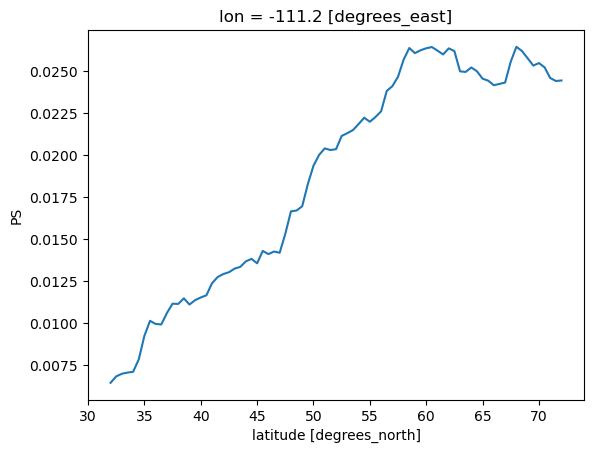

In [4]:
swe_from_phase(dry_atmosphere(np.abs(pressure_transect - pressure_transect.shift(time=12)).median('time'))).plot(label = 'pressure')


In [6]:
# for transect, function, label in zip([pw_transect, ion_transect, pressure_transect], [precipitable_water, ionospheric_advance, dry_atmosphere], ['water vapor', 'ionosphere', 'air pressure']):
#     median_12day_diff = np.abs(transect - transect.shift(time = 12)).median('time')
#     median_12day_swe_error = swe_from_phase(function(median_12day_diff))
#     median_12day_swe_error.plot(label = label)
# # swe_from_phase(precipitable_water(np.abs(pw_transect - pw_transect.shift(time=12)).median('time')).plot(label = 'water vapor')
# # swe_from_phase(ionospheric_advance(np.abs(ion_transect - ion_transect.shift(time=12)).median('time'))).plot(label = 'ionosphere')
# plt.ylabel('12 Day SWE Error [m]')
# plt.legend()

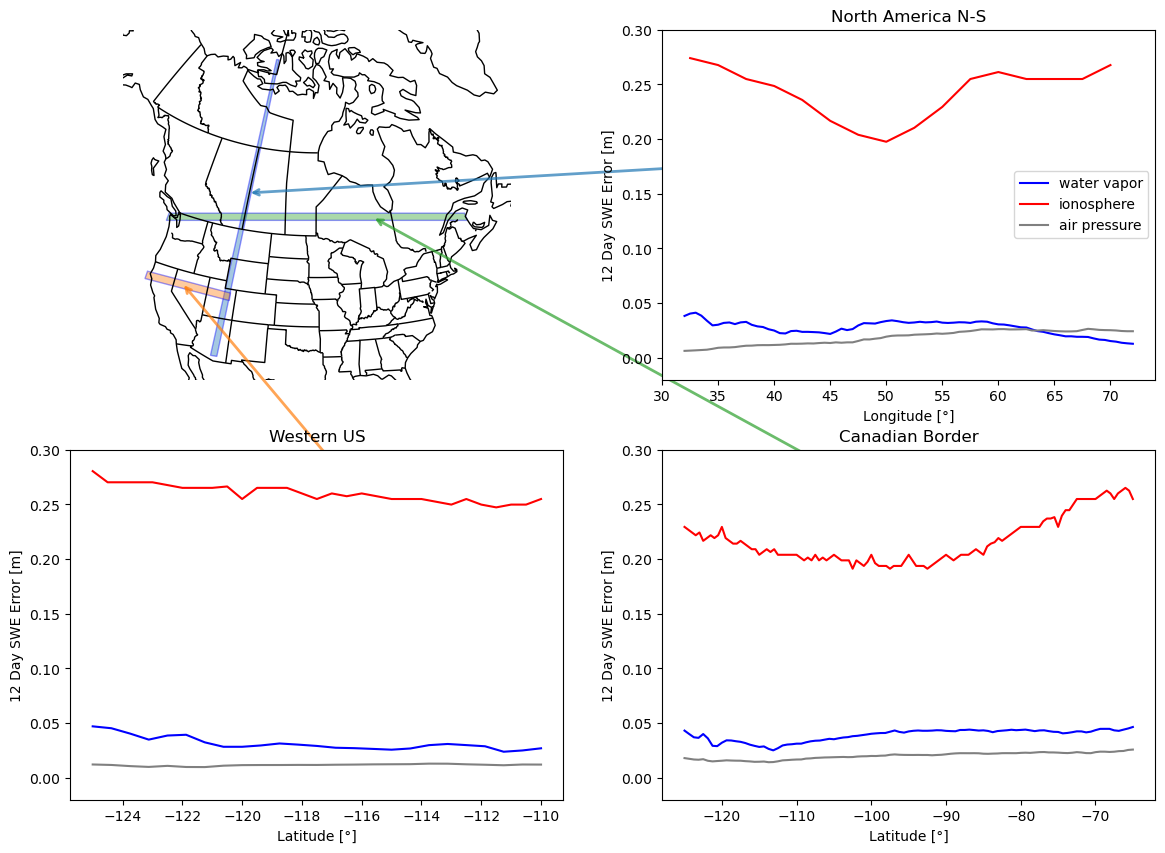

In [57]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create figure
fig = plt.figure(figsize=(14, 10))

# Upper-left: Cartopy map with EPSG:3857
# ax_map = fig.add_subplot(2, 2, 1, projection=ccrs.epsg(3857))
ax_map = fig.add_subplot(2, 2, 1, projection=ccrs.LambertAzimuthalEqualArea(central_longitude=-95, central_latitude=40))

for spine in ax_map.spines.values():
    spine.set_visible(False)


# Other subplots: Standard Matplotlib axes
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax_map.coastlines()
ax_map.add_feature(countries)
ax_map.add_feature(states_provinces)

import pyproj

# Create the transformer
# transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "ESRI:54034", always_xy=True)

minx, miny, maxx, maxy = [-125, 30, -65, 75]
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)
# minx *= 1.03
# maxx *= 0.96
# miny *= 0.9
# maxy *= 1.05
# ax_map.set_extent((minx, maxx, miny, maxy), crs=ccrs.epsg(3857))
ax_map.set_extent([-125, -65, 30, 75], crs=ccrs.PlateCarree())

from matplotlib.patches import Polygon
from cartopy.mpl.patch import geos_to_path
import cartopy.io.shapereader as shpreader

from matplotlib.ticker import FixedLocator
# Add latitude/longitude gridlines every 5 degrees
# gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                #   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = FixedLocator(range(-180, 181, 5))  # Longitude ticks
gl.ylocator = FixedLocator(range(-90, 91, 5))    # Latitude ticks
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels = False
gl.right_labels = False

dim_names = {'lat': 'Latitude [°]', 'lon': 'Longitude [°]'}
for ylims, xlims, dim, box_color, ax in zip([(32, 72), (39.5, 40.5), (47.5, 48.5)], [(-111.55, -110.55), (-125, -110), (-125, -65)], ['lon', 'lat', 'lat'], ['C0', 'C1', 'C2'], [ax2, ax3, ax4]):
    pw_transect = pw.sel(lat = slice(ylims[0], ylims[1]), lon = slice(xlims[0], xlims[1]))
    ion_transect = ion.sel(lat = slice(ylims[0], ylims[1]), lon = slice(xlims[0], xlims[1]))
    pressure_transect = am_pressure.sel(lat = slice(ylims[0], ylims[1]), lon = slice(xlims[0], xlims[1]))

    for transect, function, color, label in zip([pw_transect, ion_transect, pressure_transect], [precipitable_water, ionospheric_advance, dry_atmosphere], ['blue', 'red', 'grey'], ['water vapor', 'ionosphere', 'air pressure']):
        transect = transect.mean(dim)
        median_12day_diff = np.abs(transect - transect.shift(time = 12)).median('time')
        median_12day_swe_error = swe_from_phase(function(median_12day_diff))
        median_12day_swe_error.plot(label = label, ax = ax, color = color)
    ax.set_ylabel('12 Day SWE Error [m]')
    ax.set_ylim(-0.02, 0.3)
    ax.set_xlabel(dim_names[dim])

    # Define box corners in lon/lat
    box_coords_latlon = [
        (xlims[0], ylims[0]),
        (xlims[1], ylims[0]),
        (xlims[1], ylims[1]),
        (xlims[0], ylims[1])
    ]

    # Convert box to EPSG:3857
    # box_coords_proj = [transformer.transform(lon, lat) for lon, lat in box_coords_latlon]
    box_coords_proj = [ax_map.projection.transform_point(lon, lat, src_crs=ccrs.PlateCarree())
                   for lon, lat in box_coords_latlon]


    # Create and add the polygon
    # transect_poly = Polygon(box_coords_proj, closed=True, facecolor=box_color, edgecolor='blue', alpha=0.4, transform=ccrs.epsg(3857))
    transect_poly = Polygon(box_coords_proj, closed=True, facecolor=box_color, edgecolor='blue', alpha=0.4, transform=ax_map.projection)

    ax_map.add_patch(transect_poly)

ax2.legend()

# --- After all plotting and transect boxes added ---

fig = plt.gcf()  # get current figure

# Helper: get bbox center in figure coords
def get_bbox_center(ax):
    bbox = ax.get_position()
    return (bbox.x0 + bbox.width/2, bbox.y0 + bbox.height/2)

# Get subplot centers (arrow start points)
starts = [get_bbox_center(ax2), get_bbox_center(ax3), get_bbox_center(ax4)]

# Get transect box centers on the map in data coords (EPSG:3857)
transect_centers_data = []
for ylims, xlims in zip([(32, 72), (39.5, 40.5), (47.5, 48.5)], [(-111.55, -110.55), (-125, -110), (-125, -65)]):
    center_lon = (xlims[0] + xlims[1]) / 2
    center_lat = (ylims[0] + ylims[1]) / 2
    # center_x, center_y = transformer.transform(center_lon, center_lat)
    transect_centers_data.append((center_x, center_y))

# # Convert map data coords to display coords then to figure coords
# transect_centers_fig = []
# for x, y in transect_centers_data:
#     disp = ax_map.transData.transform((x, y))  # data -> display
#     fig_coords = fig.transFigure.inverted().transform(disp)  # display -> figure
#     transect_centers_fig.append(fig_coords)

# for start, end, color in zip(starts, transect_centers_fig, ['C0', 'C1', 'C2']):
#     ax_map.annotate("",
#                     xy=end, xycoords='figure fraction',
#                     xytext=start, textcoords='figure fraction',
#                     arrowprops=dict(arrowstyle="->", color=color, lw=2, alpha=0.7),
#                     )

# Get subplot centers (arrow starts)
starts = [get_bbox_center(ax2), get_bbox_center(ax3), get_bbox_center(ax4)]

# Get polygon centers from last 3 patches added (your transect boxes)
transect_centers_fig = []
for patch in ax_map.patches[-3:]:
    path = patch.get_path()
    verts = patch.get_transform().transform(path.vertices)
    centroid = verts.mean(axis=0)  # display coords
    fig_coords = fig.transFigure.inverted().transform(centroid)
    transect_centers_fig.append(fig_coords)

transect_centers_fig = [np.array([0.177, 0.66 ]),
 np.array([0.13, 0.57]),
 np.array([0.26590909, 0.636])]

# Draw arrows from subplot centers to polygon centers
for start, end, color in zip(starts, transect_centers_fig, ['C0', 'C1', 'C2']):
    ax_map.annotate("",
                    xy=end, xycoords='figure fraction',
                    xytext=start, textcoords='figure fraction',
                    arrowprops=dict(arrowstyle="->", color=color, lw=2, alpha=0.7),
                    )

for title, ax in zip(['North America N-S', 'Western US', 'Canadian Border'], [ax2, ax3, ax4]):
    ax.set_title(title)
    # ax.grid(True, linestyle = '--', alpha = 0.5)

plt.savefig('transect_figure.png')